In [1]:
import numpy as np
import mne
import os
from functools import partial 
import pandas as pd
import pickle
import mne

In [2]:
dir_name = '/scratch/jd5697/cv_project'

In [3]:
embeddings_train = np.load(os.path.join(dir_name, 'image_embeddings_vit_train_fmri_subset.npy'), allow_pickle=True).item()
embeddings_test = np.load(os.path.join(dir_name, 'image_embeddings_vit_test_fmri_subset.npy'), allow_pickle=True).item()
embeddings_test_small = np.load(os.path.join(dir_name, 'image_embeddings_vit_test_small_fmri_subset.npy'), allow_pickle=True).item()

print(len(embeddings_train))
print(len(embeddings_test))
print(len(embeddings_test_small))
print(len(embeddings_train) + len(embeddings_test) + len(embeddings_test_small))

6240
2400
100
8740


In [4]:
#check shape
with open('valid_epochs_all_train_fmri_subset.pickle', 'rb') as f:
    epochs_train = pickle.load(f)

with open('valid_epochs_all_test_fmri_subset.pickle', 'rb') as f:
    epochs_test = pickle.load(f)

with open('valid_epochs_all_test_small_fmri_subset.pickle', 'rb') as f:
    epochs_test_small = pickle.load(f)

print(len(epochs_train))
print(len(epochs_test))
print(len(epochs_test_small))

24960
9600
400


In [5]:
meg_data_train = epochs_train.get_data()
meg_data_train = meg_data_train.reshape(meg_data_train.shape[0], -1)

meg_data_test = epochs_test.get_data()
meg_data_test = meg_data_test.reshape(meg_data_test.shape[0], -1)

meg_data_test_small = epochs_test_small.get_data()
meg_data_test_small = meg_data_test_small.reshape(meg_data_test_small.shape[0], -1)

print(meg_data_train.shape)
print(meg_data_test.shape)
print(meg_data_test_small.shape)

(24960, 49232)
(9600, 49232)
(400, 49232)


In [6]:
embeddings_data_train = np.vstack([embeddings_train[key] for key in epochs_train.metadata['image_path']])
embeddings_data_test = np.vstack([embeddings_test[key] for key in epochs_test.metadata['image_path']])
embeddings_data_test_small = np.vstack([embeddings_test_small[key] for key in epochs_test_small.metadata['image_path']])

print(embeddings_data_train.shape)
print(embeddings_data_test.shape)
print(embeddings_data_test_small.shape)

(24960, 768)
(9600, 768)
(400, 768)


In [7]:
from cuml.preprocessing import StandardScaler
scaler = StandardScaler()
embeddings_data_train = scaler.fit_transform(embeddings_data_train)
embeddings_data_test = scaler.transform(embeddings_data_test)
embeddings_data_test_small = scaler.transform(embeddings_data_test_small)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

In [9]:
# Define the neural network
class MLPRegressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, output_size),
        )

    def forward(self, x):
        return self.model(x)

In [10]:
# Hyperparameters
input_size = meg_data_train.shape[1]
output_size = embeddings_data_train.shape[1]
max_epochs = 5000
learning_rate = 0.003
batch_size = 64
patience = 2

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare data
data_tensor = torch.tensor(meg_data_train, dtype=torch.float32).to(device)
target_tensor = torch.tensor(embeddings_data_train, dtype=torch.float32).to(device)
dataset = TensorDataset(data_tensor, target_tensor)

# Split dataset into train and validation sets
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = MLPRegressor(input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Learning rate schedule
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (1 + 0.001 * epoch))

In [11]:
# Training loop
def train_model():
    best_val_loss = float('inf')
    patience_counter = 0

    train_loss_history = []
    val_loss_history = []

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_targets).item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        # Update learning rate
        #scheduler.step()

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

Epoch [1/5000], Train Loss: 1.1211, Val Loss: 1.0865
Epoch [2/5000], Train Loss: 1.0374, Val Loss: 1.0733
Epoch [3/5000], Train Loss: 1.0006, Val Loss: 1.0689
Epoch [4/5000], Train Loss: 0.9743, Val Loss: 1.0671
Epoch [5/5000], Train Loss: 0.9526, Val Loss: 1.0678


Epoch [6/5000], Train Loss: 0.9341, Val Loss: 1.0687
Early stopping triggered.


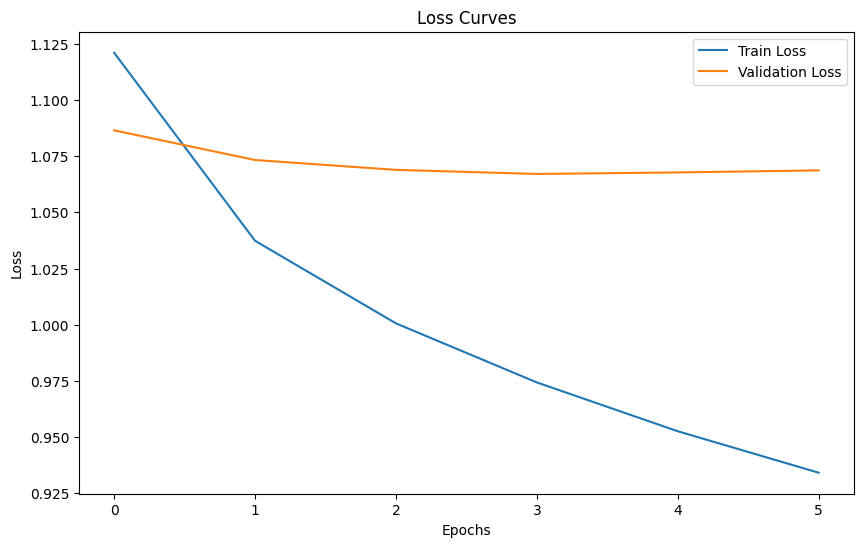

In [12]:
train_model()

In [13]:
def make_predictions(data):
    # Prepare test data
    test_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(test_tensor)
    return predictions.cpu().numpy()

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_top_k_accuracy(y_pred, y_true, k=5, num_participants=1):
    """Evaluate top-k accuracy using cosine similarity for embeddings."""
    num_indices = y_true.shape[0]/num_participants

    correct_predictions = 0

    for i in range(num_participants):
        y_pred_participant = y_pred[int(i*num_indices):int((i+1)*num_indices)]
        y_true_participant = y_true[int(i*num_indices):int((i+1)*num_indices)]
        n_samples = y_true_participant.shape[0]

        ## returns a n_samples X n_samples matrix
        similarity_matrix = cosine_similarity(y_pred_participant, y_true_participant)
        
        # Get the indices of the sorted similarities in descending order
        sorted_indices = np.argsort(-similarity_matrix, axis=1) #axis = 1 sorts across i.e. sorts across y_true for each pred
        
        # Check if the true index is within the top-k predictions for each sample
        for i in range(n_samples):
            if i in sorted_indices[i, :k]:
                correct_predictions += 1
    
    top_k_acc = correct_predictions / y_true.shape[0]
    return top_k_acc

In [15]:
top_5_acc = evaluate_top_k_accuracy(make_predictions(meg_data_test), embeddings_data_test, k=5, num_participants=4)
print(f"Top-5 accuracy: {top_5_acc:.4f}")

Top-5 accuracy: 0.0082


In [16]:
top_5_acc = evaluate_top_k_accuracy(make_predictions(meg_data_test_small), embeddings_data_test_small, k=5, num_participants=4)
print(top_5_acc)

0.1325


In [17]:
top_5_acc = evaluate_top_k_accuracy(make_predictions(meg_data_train), embeddings_data_train, k=5, num_participants=4)
print(top_5_acc)

0.6777644230769231


In [18]:
#Save the PyTorch model
torch.save(model.state_dict(), os.path.join(dir_name, 'meg_mlp_fmri_subset.pth'))